In [12]:
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2gray
from scipy.ndimage import center_of_mass

def convert_image_array_to_slic_with_properties(image_array, n_segments=100, compactness=10, sigma=1):
    """
    Convert an image array to a segmented grayscale image using SLIC (Simple Linear Iterative Clustering) algorithm,
    and calculate properties for each superpixel including color, centroid x, centroid y, and number of pixels.

    Args:
        image_array (numpy.ndarray): Input image array in black and white.
        n_segments (int, optional): Number of segments in SLIC. Default is 100.
        compactness (float, optional): Compactness parameter for SLIC. Default is 10.
        sigma (float, optional): Sigma parameter for SLIC. Default is 1.

    Returns:
        segmented_image_gray (numpy.ndarray): Segmented grayscale image.
        properties (numpy.ndarray): Array of dictionaries containing properties for each superpixel.
    """
    image_rgb = np.stack((image_array,) * 3, axis=-1)
    segments = slic(image_rgb, n_segments=n_segments, compactness=compactness, sigma=sigma)
    segmented_image = np.zeros_like(image_rgb)
    properties = []  # List to store properties

    for segment_id in np.unique(segments):
        mask = segments == segment_id
        segment_rgb = image_rgb[mask]

        if np.any(mask):
            num_pixels = np.sum(mask)
            centroid = center_of_mass(mask)
            centroid_x, centroid_y = centroid
            mean_color = np.mean(segment_rgb, axis=0)

            properties.append({
                'color': mean_color, # RGB color values
                'centroid_x': centroid_x, # x coordinate of centroid
                'centroid_y': centroid_y, # y coordinate of centroid
                'num_pixels': num_pixels # number of pixels in superpixel
            })

            segmented_image[mask] = mean_color
    
    properties = np.array(properties)  # Convert properties list to numpy array

    segmented_image_gray = rgb2gray(segmented_image) # Convert segmented image to grayscale
    return segmented_image_gray, properties


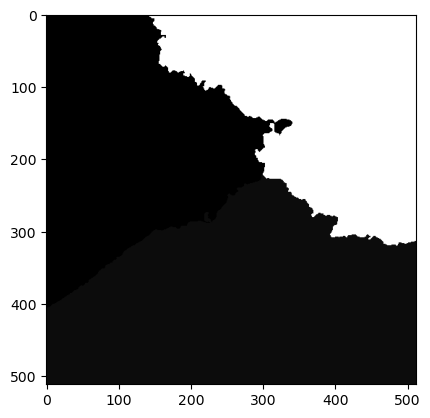

In [25]:
# Usage

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Load the JPEG image using PIL
image_path = 'gg.jpeg'  # Replace with the actual path to your JPEG image
image = Image.open(image_path)

# Convert the PIL image to a numpy array
image_arr = np.array(image)
image_arr=rgb2gray(image_arr)
plt.imshow(convert_image_array_to_slic_with_properties(image_arr,n_segments=3)[0],cmap='gray')